<a href="https://colab.research.google.com/github/ymatsumoto73/Detour-phase-hologram/blob/main/binary_hologram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detour phase hologram

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Execution time: 2.055114507675171 seconds


<Figure size 1500x1500 with 0 Axes>

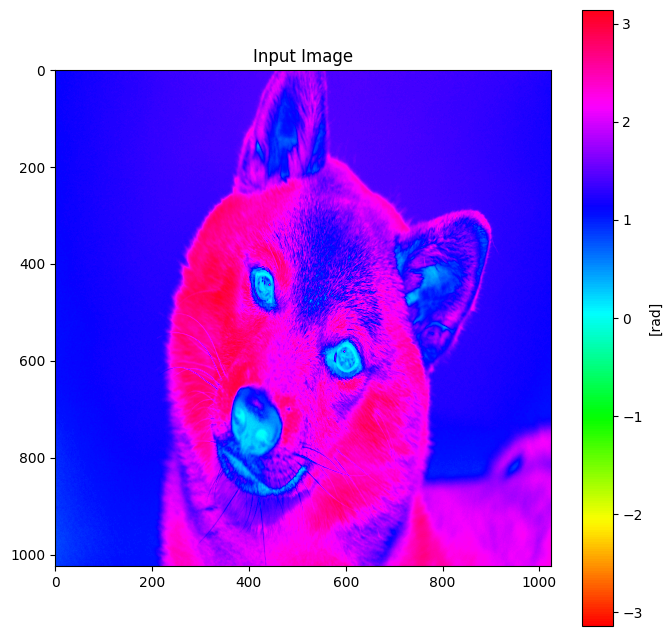

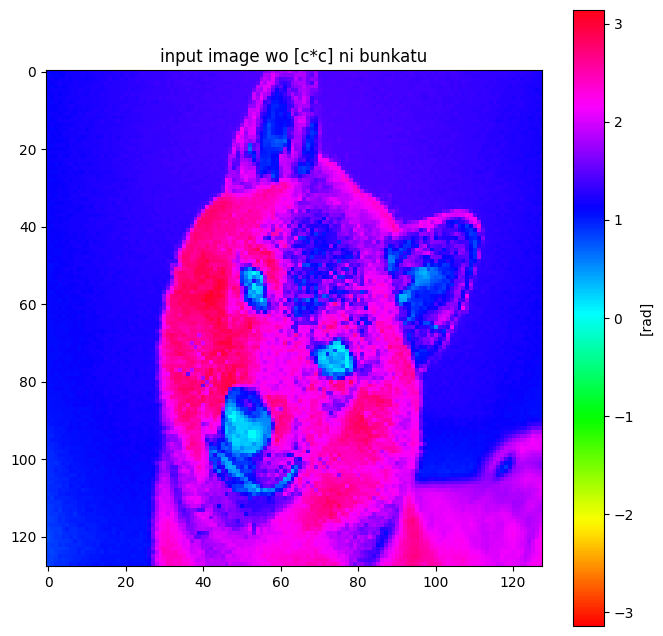

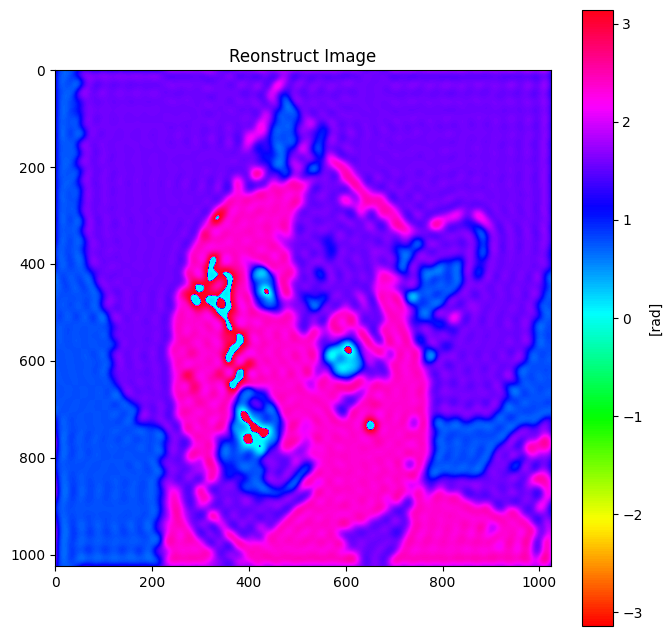

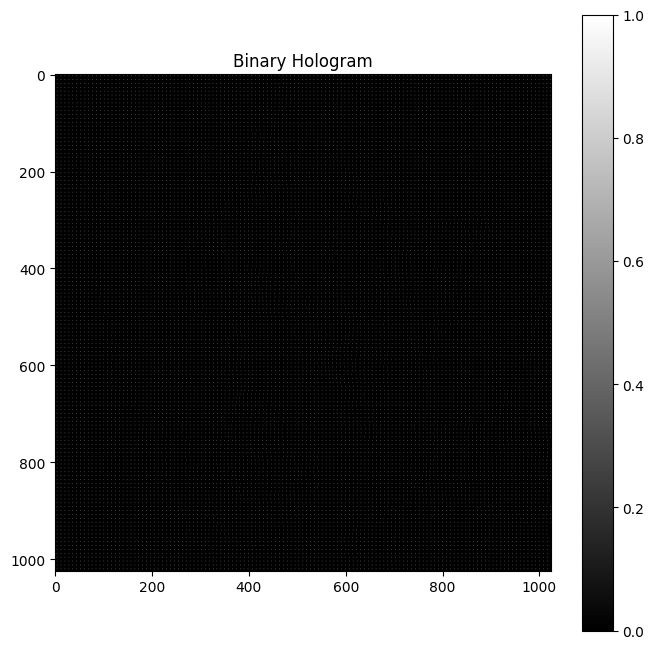

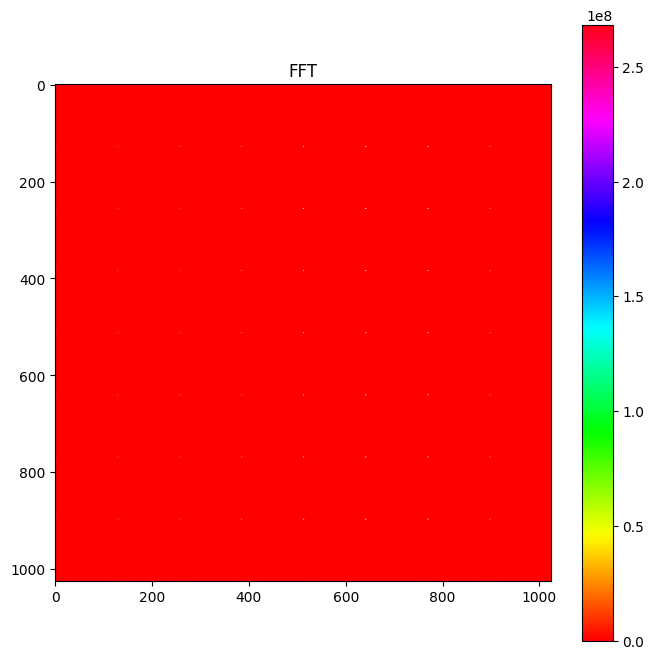

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv
from sklearn.metrics import mean_squared_error
from IPython.display import HTML
import time

from google.colab import drive
drive.mount('/content/drive')

image_path = '/content/drive/My Drive/image/innu1.jpg'  # 画像の指定
#image_path = '/content/drive/My Drive/image/rissu.jpg

start_time = time.time()

# 定数の設定
amp = 1  # 振幅の定数

# 全体の領域のピクセル数
N = 1024 #pix
# セルの分割数（これが全体の領域に対してc*c)
c =  128 #個
# セル内の最小単位のピクセル数(分割数？)
u = N // c   #pix

# 1ピクセルあたりの大きさ（任意に設定）
pixel_x = 1


# セルサイズ
cell_size = u * pixel_x  #m

# 波長（任意の値）
lambda_ = 532e-9   #m

# 入力画像の読み込み
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


# 画像のリサイズ
image = cv2.resize(image, (N, N))
image = image.astype(np.float32)
image = (image / 255.0) * np.pi  # 正規化
c_image = cv2.resize(image, (c, c))

# 物体光の複素振幅の計算
phase = tf.constant(image, dtype=tf.float32)
uo = amp * tf.exp(1j * tf.cast(phase, tf.complex64))


# スリットホログラムの生成
def generate_hologram(uo, N, c, u, pixel_x):
    global amp, phi
    global cell_size, cell_amp
    global y_start, y_end, x_start, x_end
    global total_area, ave_phase

    amp = np.abs(uo)
    phi = np.angle(uo)
    cell_amp = amp

    holo = np.zeros((N, N), dtype=np.float32)
    total_area = 0

    for i in range(c):
      for j in range(c):
          # 各セルの座標の設定
          x_start = j * u
          x_end = x_start + u
          y_start = i * u
          y_end = y_start + u
          x_center = j * u + u // 2
          y_center = i * u + u // 2

          # セル全体を0(黒)に塗りつぶす
          holo[y_start:y_end, x_start:x_end] = 0

          # セル内の振幅と位相を計算
          ave_amp = np.mean(cell_amp[y_start:y_end, x_start:x_end])
          ave_phase = np.mean(phi[y_start:y_end, x_start:x_end])
          #print(ave_amp,"|", ave_phase)

          # # 副セルの大きさを計算
          # # ゼロ除算を防ぐためのチェックを追加
          # if cell_size != 0:
          #     wx = ave_amp / cell_size
          # else:
          #     wx = 0  # または適切に処理
          # wy = 7  # 副セルの高さ

          wx = np.sqrt(ave_amp)
          wy = ave_amp / wx

          if wy > u:
            wy = u
          if wx > u:
            wx = u

          # 位相による副セルの中心位置調整(Px = phi*dx/2π,  -dx/2 <= Px <= dx/2))
          Px = ave_phase * u / (2 * np.pi)
          max_Px = (u - wx) / 2
          min_Px = - max_Px
          Px = np.clip(Px, min_Px, max_Px)  # Pxを範囲内に制限
          ad_x_center = x_center + Px
          #print("Px, max_Px, min_Px, ad_x_center ||   ", Px, "|", max_Px, "|", min_Px, "|", ad_x_center)



          # 副セルの始まりと終わりの座標を計算
          x_start_sub = int(max(ad_x_center - wx / 2, x_start))
          x_end_sub = int(min(ad_x_center + wx / 2, x_end))
          y_start_sub = int(max(y_center - wy / 2, y_start))
          y_end_sub = int(min(y_center + wy / 2, y_end))


          # 副セル部分を1.0に設定
          holo[y_start_sub:y_end_sub, x_start_sub:x_end_sub] = 1.0

          # 副セルの面積を計算してtotal_areaに追加
          sub_cell_area = (x_end_sub - x_start_sub) * (y_end_sub - y_start_sub) * (1 ** 2)
          total_area += sub_cell_area

    return holo, total_area ,ave_phase


# ホログラムの生成
holo, total_area,ave_phase = generate_hologram(uo.numpy(), N, c, u, pixel_x)


# 参照光の設定
p, q = np.meshgrid(np.arange(1, N + 1), np.arange(1, N + 1))
k = 2 * np.pi / lambda_
theta = np.arcsin(lambda_ / cell_size)  # 参照光の角度
#theta = 6 / np.pi
dosuu = theta * 180 / np.pi

# 参照光の計算
ur = amp * np.exp(1j * k * (p - (N / 2) * pixel_x) * np.sin(theta))



#⑤ ホログラムの再生
# 再生光の複素振幅分布
u2 = holo * ur

F_u2 = np.fft.fftshift(np.fft.fft2(u2))  #fft.fft2で離散フーリエ変換，fft.fftshiftで中心にシフト

FT_image = np.abs(F_u2) ** 2

### フーリエ変換に対しての処理（フーリエ変換法）
# 中心領域の切り取り
N_cut = 60
centerX = N // 2  # 中心位置　※「//」・・・割り算の小数部を切り捨てる
centerY = N // 2

# 物体光が中心にない時（基本的に使わなくてもいい）
x_shift = 0   # x軸方向への平行移動
y_shift = 0   # y軸方向の平行移動

# 切り取り範囲の指定
start_x = centerX - (N_cut // 2) + x_shift
start_y = centerY - (N_cut // 2) + y_shift

# クリッピング(範囲の調整のこと)
startX = max(1, min(start_x, N - N_cut + 1))
startY = max(1, min(start_y, N - N_cut + 1))

center_image = F_u2[startY:startY + N_cut, startX:startX + N_cut] # 切り取った画像
cut_image1 = np.pad(center_image, ((N - N_cut) // 2, (N - N_cut) // 2), 'constant') #ゼロパディング
cut_image2 = np.abs(cut_image1) ** 2  # 切り取った画像の強度分布

# 切り取った画像に対して逆フーリエ変換
IFT_u2 = np.fft.ifft2(np.fft.fftshift(cut_image1))

# 逆フーリエ変換した画像のカメラ面での分布
cropSize = N
xStart = max(0, centerX - cropSize // 2)
xEnd = min(N, centerX + cropSize // 2)
yStart = max(0, centerY - cropSize // 2)
yEnd = min(N, centerY + cropSize // 2)

t_image = holo[yStart:yEnd, xStart:xEnd] #カメラが捉える範囲
IFT_image = IFT_u2[yStart:yEnd, xStart:xEnd] #カメラが捉える範囲

IFT_amp = np.abs(IFT_image) ** 2  #出力の強度分布
IFT_angle = np.angle(IFT_image)  #出力の位相分布

read_resized = (cv2.resize(IFT_angle, (N, N)) + np.pi) % np.pi

c_resized = cv2.resize(c_image, (N, N)) #分割したやつとのMSEを測るためにリサイズ


end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")


#　位相差を計算する[mse, rmse, mae]
def phase_comparison(image1, image2):
    phase_difference = np.sqrt((np.cos(image1) - np.cos(image2))**2 +
                               (np.sin(image1) - np.sin(image2))**2)
    mse = np.mean(phase_difference**2)
    rmse = np.sqrt(mse)
    mae = np.mean(phase_difference)
    difference = phase_difference

    return mse, rmse, mae, difference

# 位相の差異を計算
mse, rmse, mae, difference = phase_comparison(image, read_resized)
#mse, rmse, mae, difference = phase_comparison(c_resized, read_resized)

#⑥ 結果の表示
plt.figure(figsize=(15, 15))

display(HTML(f'<h2>MSE :  {mse}</h2>'))



def plot_image(image, title, cmap='hsv', cbar_label=None, vmin=None, vmax=None):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    img = plt.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(img)
    if cbar_label:
        cbar.set_label(cbar_label)
    plt.show()


# 入力画像の表示
plot_image(image, 'Input Image', cbar_label='[rad]', vmin=-np.pi, vmax=np.pi)
plot_image(c_image, 'input image wo [c*c] ni bunkatu', cbar_label='[rad]', vmin=-np.pi, vmax=np.pi)

# 表示
plot_image(read_resized,"Reonstruct Image", cbar_label='[rad]', vmin=-np.pi, vmax=np.pi)
plot_image(holo, 'Binary Hologram', cmap = "gray") #ホログラム
plot_image(FT_image, 'FFT') # フーリエ変換結果


# with open('/home/input_image.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerows(image)
# with open('/home/reconstruct.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerows(read_resized)

# with open('/home/Fu2.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerows(F_u2)




# Off axis hologram

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Execution time: 0.3386697769165039 seconds


<Figure size 1500x1500 with 0 Axes>

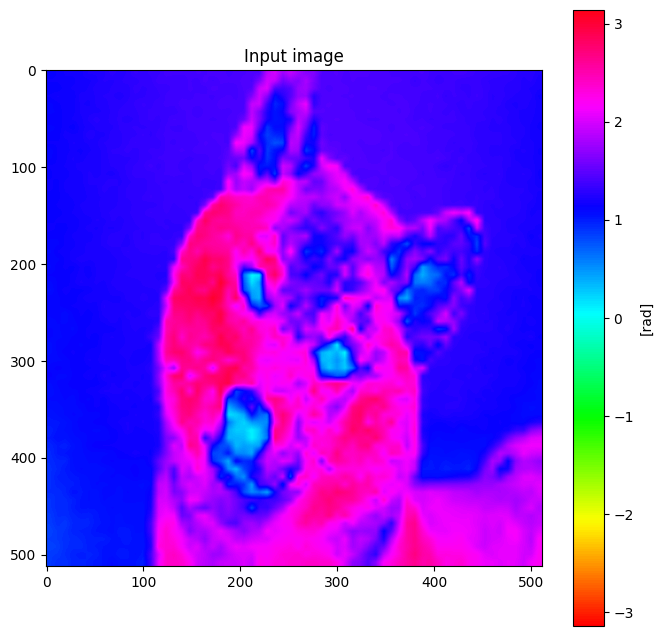

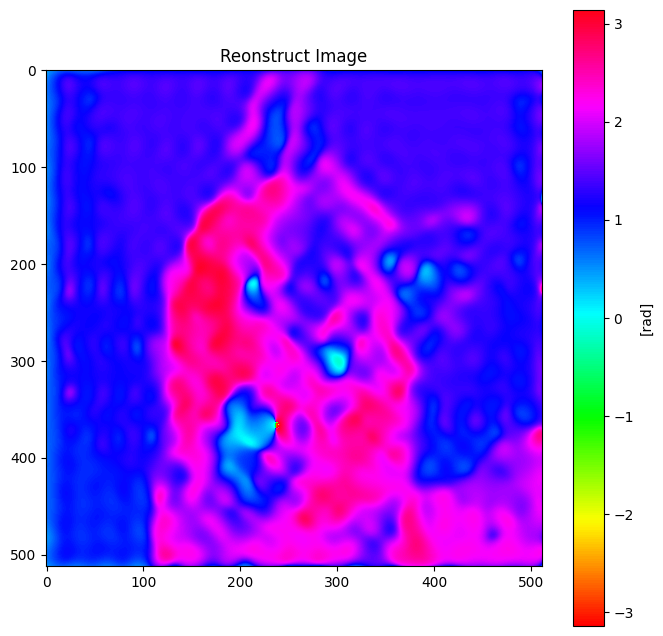

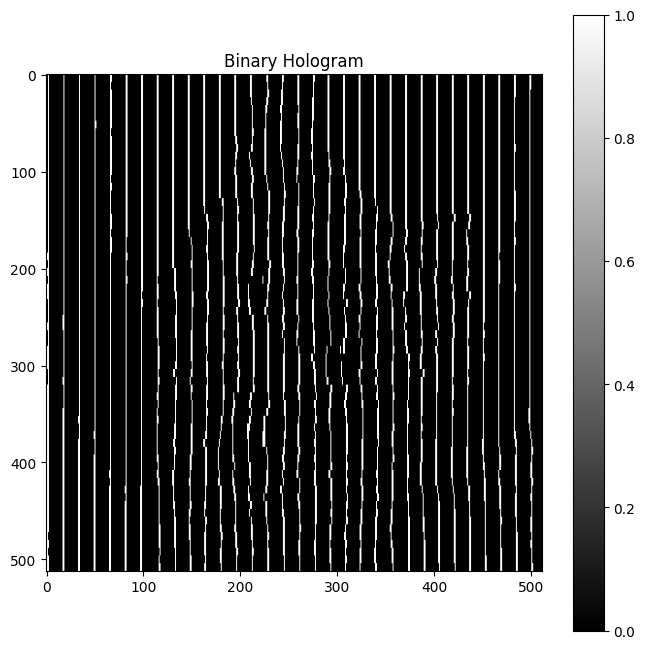

In [6]:
# 軸外ホログラム法

import numpy as np  # NumPyを接頭語npを使うことで利用できる
import cv2          # OpenCVを利用できる（画像処理等）
import matplotlib.pyplot as plt # matplotlib.pyplotを接頭語pltを使うことで利用できる
import csv
import time

from PIL import Image #　画像を読み込んで処理できる
from sklearn.metrics import mean_squared_error
from IPython.display import HTML


from google.colab import drive
drive.mount('/content/drive')

image_path = '/content/drive/My Drive/image/innu1.jpg'  # 画像の指定
#image_path = '/content/drive/My Drive/image/rissu.jpg

start_time = time.time()
#①　パラメータ設定
# ピクセルの設定
N_image = 64      #画像のピクセル数
N_calc_tmp = 512  #正味の計算領域？DMD面
N_device = 512      #カメラのピクセル数
N_calc = N_calc_tmp * 2       #計算領域のピクセル数
#N_calc = 1024
N_slm = 64          #SLM（理想的）のピクセル数

# 入力画像の座標行列を生成
p, q = np.meshgrid(np.arange(1, N_calc + 1), np.arange(1, N_calc + 1))


# 条件の設定
lambda_ = 532e-9 #波長　※'lambda'は使えない
phi = 0            #参照光とx軸のなす角度（rad)
k = 2 * np.pi / lambda_   # 波数

# pixelの大きさの設定
d_i = 16.0e-6    #画像の1ピクセルの大きさ
d_d = 2.0e-6     #カメラの1ピクセルの大きさ
d_c = 1.0e-6     #計算領域の1ピクセルの大きさ
d_s = 16.0e-6    #SLM(理想的)の1ピクセルの大きさ

theta = np.arcsin(lambda_ / (d_s * (2 / 2)))  #参照光とz軸のなす角度（rad)
#theta = np.pi / 6



#② 画像の読み込み
# 位相
phase_org = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) #グレースケールで読み込み
phase_gray = cv2.resize(phase_org, (N_image, N_image)) / 255.0  * np.pi   #リサイズと正規化(0～1) & πいそうへんちょう
phase_OS = np.kron(phase_gray, np.ones((N_calc_tmp // N_image, N_calc_tmp // N_image))) # オーバーサンプリング
phase_pad = np.pad(phase_OS, ((N_calc - N_calc_tmp) // 2, (N_calc - N_calc_tmp) // 2), 'constant') # ゼロパディング
phase = phase_pad

# 振幅　※改善あり
amp_org = 1.0
amp = amp_org

#③ ホログラムの記録
# 物体光の複素振幅分布(uo = exp(jφ(x,y))) [位相変調は0~π]
uo = amp * np.exp(1j * phase)

# 参照光の複素振幅(ur = exp(jk(p-(Nx/2))dx・sinθ)
ur = np.exp(1j * k * (p - (N_calc / 2)) * d_c * np.sin(theta))

# 干渉光の複素振幅分布
u1 = uo + ur

# 干渉光の強度分布
I = np.abs(u1) ** 2



#④ 透過率の設定（バイナリかどうかも）

t = I
t = np.where(I < 3.9, 0, 1) # 0.5未満なら0, 0.5以上なら1を返す


#⑤ ホログラムの再生
# 再生光の複素振幅分布
u2 = t * ur

# 再生光のフーリエ変換
F_u2 = np.fft.fftshift(np.fft.fft2(u2)) #fft.fft2で離散フーリエ変換，fft.fftshiftで中心にシフト


FT_image = np.abs(F_u2) ** 2

### フーリエ変換に対しての処理（フーリエ変換法）
# 中心領域の切り取り
N_cut = 64
centerX = N_calc // 2  # 中心位置　※「//」・・・割り算の小数部を切り捨てる
centerY = N_calc // 2

# 物体光が中心にない時（基本的に使わなくてもいい）
x_shift = 0   # x軸方向への平行移動
y_shift = 0   # y軸方向の平行移動

# 切り取り範囲の指定
start_x = centerX - (N_cut // 2) + x_shift
start_y = centerY - (N_cut // 2) + y_shift

# クリッピング(範囲の調整のこと)
startX = max(1, min(start_x, N_calc - N_cut + 1))
startY = max(1, min(start_y, N_calc - N_cut + 1))

center_image = F_u2[startY:startY + N_cut, startX:startX + N_cut] # 切り取った画像
cut_image1 = np.pad(center_image, ((N_calc - N_cut) // 2, (N_calc - N_cut) // 2), 'constant') #ゼロパディング
cut_image2 = np.abs(cut_image1) ** 2  # 切り取った画像の強度分布

# 切り取った画像に対して逆フーリエ変換
IFT_u2 = np.fft.ifft2(np.fft.fftshift(cut_image1))
#IFT_u2 = np.ifft2(fftshift(cut_image1))

# 逆フーリエ変換した画像のカメラ面での分布
cropSize = N_calc - N_calc_tmp
xStart = max(0, centerX - cropSize // 2)
xEnd = min(N_calc, centerX + cropSize // 2)
yStart = max(0, centerY - cropSize // 2)
yEnd = min(N_calc, centerY + cropSize // 2)

t_image = t[yStart:yEnd, xStart:xEnd] #カメラが捉える範囲
IFT_image = IFT_u2[yStart:yEnd, xStart:xEnd] #カメラが捉える範囲

IFT_amp = np.abs(IFT_image) ** 2  #出力の強度分布
IFT_angle = np.angle(IFT_image)  #出力の位相分布

read_resized = cv2.resize(IFT_angle, (N_device, N_device))


in_image = (phase_gray + np.pi) % np.pi   # * np.pi
# img_OS = np.kron(phase_gray, np.ones((N_calc // N_image, N_calc // N_image)))

img_resized = cv2.resize(in_image, (N_calc_tmp, N_calc_tmp))
#img_resized = cv2.resize(in_image, (N_image, N_image))

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")



#　位相差を計算する[mse, rmse, mae]
def phase_comparison(image1, image2):
    phase_difference = np.sqrt((np.cos(image1) - np.cos(image2))**2 + (np.sin(image1) - np.sin(image2))**2)
    mse = np.mean(phase_difference**2)
    rmse = np.sqrt(mse)
    mae = np.mean(phase_difference)
    difference = phase_difference

    return mse, rmse, mae, difference

# 位相の差異を計算
mse, rmse, mae, difference = phase_comparison(img_resized, read_resized)
# mse, rmse, mae, difference = phase_comparison(in_image, read_resized)

#⑥ 結果の表示
plt.figure(figsize=(15, 15))

display(HTML(f'<h2>MSE :  {mse}</h2>'))
# print('\033[1mRMSE:\033[0m', str(rmse).upper())  # RMSEを大文字で表示
# print('\033[1mMAE: \033[0m', str(mae).upper())  # MAEを大文字で表示



# プロット関数
def plot_image(image, title, cmap='hsv', cbar_label=None, vmin=None, vmax=None):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    img = plt.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(img)
    if cbar_label:
        cbar.set_label(cbar_label)
    plt.show()

plot_image(img_resized, 'Input image', cbar_label='[rad]', vmin=-np.pi, vmax=np.pi) # フーリエ変換結果
plot_image(read_resized,"Reonstruct Image", cbar_label='[rad]', vmin=-np.pi, vmax=np.pi)
plot_image(t_image, 'Binary Hologram',cmap = "gray") #ホログラム


# with open('/home/input_image.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerows(img_resized)
# with open('/home/reconstruct.csv', 'w') as f:
#     writer = csv.writer(f)
#     writer.writerows(read_resized)

